# Lacam integration

In [1]:
import numpy as np
import os
import time

from pogema import pogema_v0, GridConfig
from pogema.animation import AnimationMonitor, AnimationConfig
from IPython.display import SVG, display
from pogema.a_star_policy import h, GridMemory, a_star
from pogema import GridConfig

In [7]:
def save_bool_array_to_map_file(bool_array, file_path):
    height = bool_array.shape[0]
    width = bool_array.shape[1]

    map_row = lambda row: ''.join('@' if x else '.' for x in row)

    map_content = '\n'.join(map_row(row) for row in bool_array)

    file_content = f"type octile\nheight {height}\nwidth {width}\nmap\n{map_content}"
    
    with open(file_path, "w") as file:
        file.write(file_content)

def save_task_to_file(map_size, global_xy, global_target_xy, file_path):
    with open(file_path, "w") as file:
        file.write("version 1\n")
        file.write(f"1	tmp.map	{map_size[0]}	{map_size[1]}	")
        file.write(f"{global_xy[1]}	{global_xy[0]}	{global_target_xy[1]}	{global_target_xy[0]}	1")

def parse_solution_data(file_path, offset):
    with open(file_path) as f:
        file_content = f.read()
    
    lines = file_content.split('\n')
    
    start_index = next(i for i, line in enumerate(lines) if line.startswith('solution='))
    moves = []
    for line in lines[start_index+1:]:
        if line.strip() == "":
            break
        coords = line.split(':')[1].strip('(),')
        x, y = map(int, coords.split(','))
        moves.append((y-offset, x-offset))
    
    return moves

class LacamAgent:
    def __init__(self, lacam_bin, seed=0):
        self._moves = GridConfig().MOVES
        self._reverse_actions = {tuple(self._moves[i]): i for i in range(len(self._moves))}

        self._gm = None
        self._saved_xy = None
        self.clear_state()
        self._rnd = np.random.default_rng(seed)

        self.lacam_bin = lacam_bin
        self.tmp_scene = "tmp.scene"
        self.tmp_map = "tmp.map"
        self.tmp_results = "tmp_results.txt"

    def run_lacam(self):
        cmd = f'{self.lacam_bin} -i {self.tmp_scene} -m {self.tmp_map} -N 1 -o {self.tmp_results}'
        os.system(cmd)

    def find_lacam_path(self, xy, target_xy, agents):
        save_bool_array_to_map_file(self._gm._memory, self.tmp_map)
        r = self._gm._memory.shape[0] // 2
        global_xy = (xy[0] + r, xy[1] + r)
        global_target_xy = (target_xy[0] + r, target_xy[1] + r)

        save_task_to_file(self._gm._memory.shape, global_xy, global_target_xy, self.tmp_scene)
        self.run_lacam()
        lacam_path = parse_solution_data(self.tmp_results, r)

        return lacam_path

    def act(self, obs, use_astar=False):
        xy, target_xy, obstacles, agents = obs['xy'], obs['target_xy'], obs['obstacles'], obs['agents']

        if self._saved_xy is not None and h(self._saved_xy, xy) > 1:
            raise IndexError("Agent moved more than 1 step. Please, call clear_state method before new episode.")
        if self._saved_xy is not None and h(self._saved_xy, xy) == 0 and xy != target_xy:
            return self._rnd.integers(len(self._moves))
        
        self._gm.update(*xy, obstacles)
        astar_path = a_star(xy, target_xy, self._gm)
        path = self.find_lacam_path(xy, target_xy, agents)
        
        if use_astar:
            path = astar_path

        if len(path) <= 1:
            action = 0
        else:
            (x, y), (tx, ty), *_ = path
            action = self._reverse_actions[tx - x, ty - y]
        
        self._saved_xy = xy
        return action

    def clear_state(self):
        self._saved_xy = None
        self._gm = GridMemory()


class BatchLacamAgent:
    def __init__(self, lacam_bin="../lacam3/build/main"):
        self.lacam_agents = {}
        self.lacam_bin = lacam_bin

    def act(self, observations, use_astar=False):
        actions = []
        for idx, obs in enumerate(observations):
            if idx not in self.lacam_agents:
                self.lacam_agents[idx] = LacamAgent(self.lacam_bin)
            actions.append(self.lacam_agents[idx].act(obs, use_astar=use_astar))
        return actions

    def reset_states(self):
        self.lacam_agents = {}

In [8]:
NUM_AGENTS = 8
MAX_STEPS = 200
grid_config = GridConfig(num_agents=NUM_AGENTS, size=15, density=0.3, seed=1, max_episode_steps=MAX_STEPS, obs_radius=3,
                         observation_type='POMAPF', collission_system='soft', on_target='restart')

env = pogema_v0(grid_config)
env = AnimationMonitor(env)
agent = BatchLacamAgent()

def run_planner(env, agent, use_astar):
    mode = "AStar" if use_astar else "Lacam"
    print(f'Running {mode} planner')
    obs, info = env.reset()
    agent.reset_states()

    time_start = time.time()
    while True:
        actions_agent = agent.act(obs, use_astar=use_astar)
        obs, reward, terminated, truncated, info = env.step(actions_agent)
        if all(terminated) or all(truncated):
            break

    time_end = time.time()
    print(f'Time elapsed: {round(time_end - time_start, 1)}s')

    env.save_animation(f"{mode}.svg", AnimationConfig(egocentric_idx=0))
    print(f'Saved result to "{mode}.svg')

run_planner(env, agent, True)
run_planner(env, agent, False)

Running AStar planner
Time elapsed: 12.4s
Saved result to "AStar.svg
Running Lacam planner
Time elapsed: 12.3s
Saved result to "Lacam.svg


'AStar Algorithm Visualization'

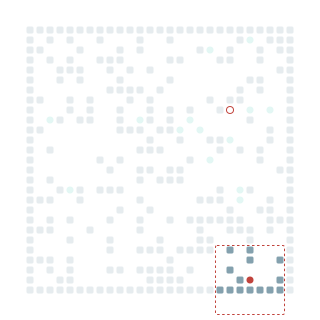

'Lacam Algorithm Visualization'

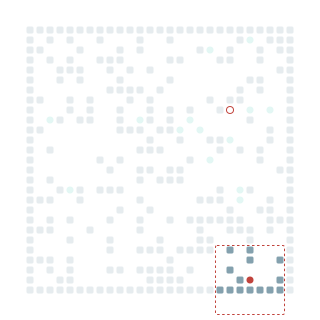

In [9]:
display("AStar Algorithm Visualization")
display(SVG('AStar.svg'))
display("Lacam Algorithm Visualization")
display(SVG('Lacam.svg'))